<a href="https://colab.research.google.com/github/dkanzariya/Python/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

most common neural net mistakes: 1) you didn't try to overfit a single batch first.

2) you forgot to toggle train/eval mode for the net.

3) you forgot to .zero_grad() (in pytorch) before .backward().

4) you passed softmaxed outputs to a loss that expects raw logits;

5) you didn't use bias=False for your Linear/Conv2d layer when using BatchNorm, or conversely forget to include it for the output layer .This one won't make you silently fail, but they are spurious parameters

6) thinking view() and permute() are the same thing (& incorrectly using view)

In [4]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

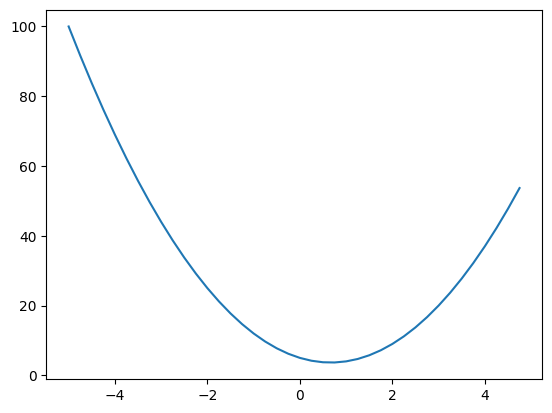

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00001 # (0.0000000000000000000001 == 0)
x = 2/3 #-3 #3
(f(x+h) - f(x))/h #(6*x - 4) = 14

3.0000002482211127e-05

In [6]:
#complex
a = 2
b = -3
c = 10
d = a*b + c
print (d)

4


In [7]:
h = 0.001

#inputs
a = 2
b = -3
c = 10

d1 = a*b + c
# a += h
# b += h
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4
d2 4.0009999999999994
slope 0.9999999999994458


In [5]:
#without repr
#   <__main__.Value object at 0x7e22908b5bd0>
# <__main__.Value object at 0x7e22908b7070>
# <__main__.Value object at 0x7e22908b6470>

class Value:
  def __init__(self, data, _children=(), _op='', label = ''):
    self.data = data
    self._prev = set(_children)
    self._backward = lambda: None
    self._op = _op
    self.grad = 0.0
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad  += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), " hgsdh"
    out = Value(self.data ** other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  def __neg__(self):
    return self * (-1)

  def __sub__(self, other):
    return self + (-other)

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - (t)**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label = 'a')
# print(a)
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
# print(a + b) #a.__add__(b)
# print((a.__mul__(b)).__add__(c))
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f ; L.label = 'L'
o = L.tanh()
# print(d._prev, d._op)
o

Value(data=-0.9999997749296758)

In [39]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [71]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

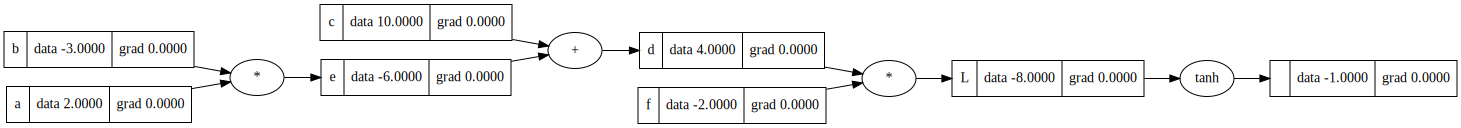

In [10]:
draw_dot(o)

In [ ]:
from logging.config import dictConfig
L = d*f

dL/dd = f

(f(x+h) - f(x))/h
((d+h)*f - d*f)/h
(d*f + h*f - d*h)/h
(h*f)/h
f

dd/dc 1
d = c+e

chain rule = mulptiply dz/dx = (dz/dy) * (dy/dx)

want:
dl / dc = (dl/dd) * (dd/dc)

know:
dl/dd
dd/dc


+ sign just route back ther derivates, + sign aleays derivatives is 1, so dd/dc = 1, dl/dc = dl/dd = f
* sign is previous derivative multiple by other value

a*b = e

de/da = b
de/db = a

In [ ]:
L.grad = 1
d.grad = f = -2.0
f.grad = d = 4
c.grad = -2.0 = f
e.grad = -2.0 = f

In [ ]:
def lol():

  h = 0.0001

  a = Value(2.0, lable = 'a')
  b = Value(-3.0, lable = 'b')
  c = Value(10.0, lable = 'c')
  e = a*b; e.lable = 'e'
  d = e + c; d.lable = 'd'
  f = Value(-2.0, lable = 'f')
  L = d * f ; L.lable = 'L'
  L1 = L.data

  a = Value(2.0, lable = 'a')
  b = Value(-3.0, lable = 'b')
  c = Value(10.0, lable = 'c')
  e = a*b; e.lable = 'e'
  d = e + c; d.lable = 'd'
  d.data += h
  f = Value(-2.0 , lable = 'f')
  L = d * f ; L.lable = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-1.9999999999953388


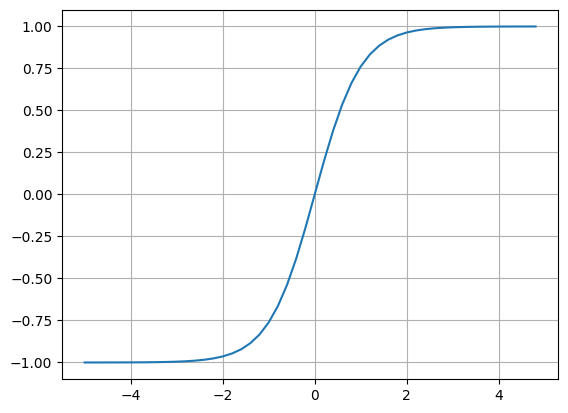

In [ ]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [44]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2 * n).exp()
o = (e - 1)/(e + 1)
# o = n.tanh(); o.label = 'o'
# ---
o.backward()

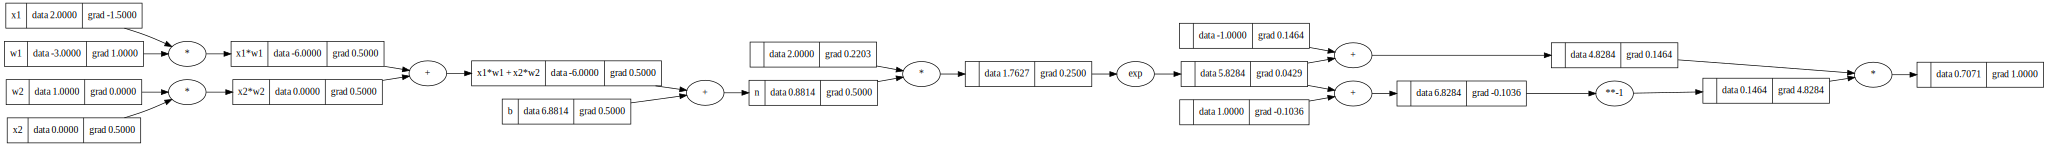

In [45]:
draw_dot(o)

In [ ]:
o.backward()

In [ ]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

In [ ]:
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x2w2.grad = 0.5
x1w1.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [ ]:
# o = tanh(n)
# do/dn = 1 - (tanh(n))**2 = 1 - 0.7071**2

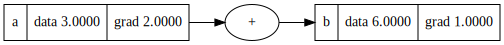

In [ ]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

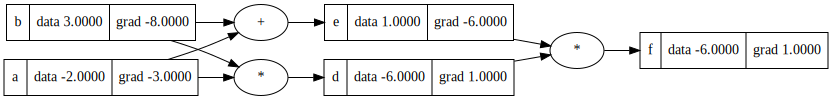

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [46]:
import torch

In [47]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [48]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [49]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [50]:
o.item()

0.7071066904050358

In [51]:
o.data.item()

0.7071066904050358

In [68]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    # act = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b
    out = act.tanh()
    # print(list(zip(self.w, x)))
    return out

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer (sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)

    return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9525873989242399)

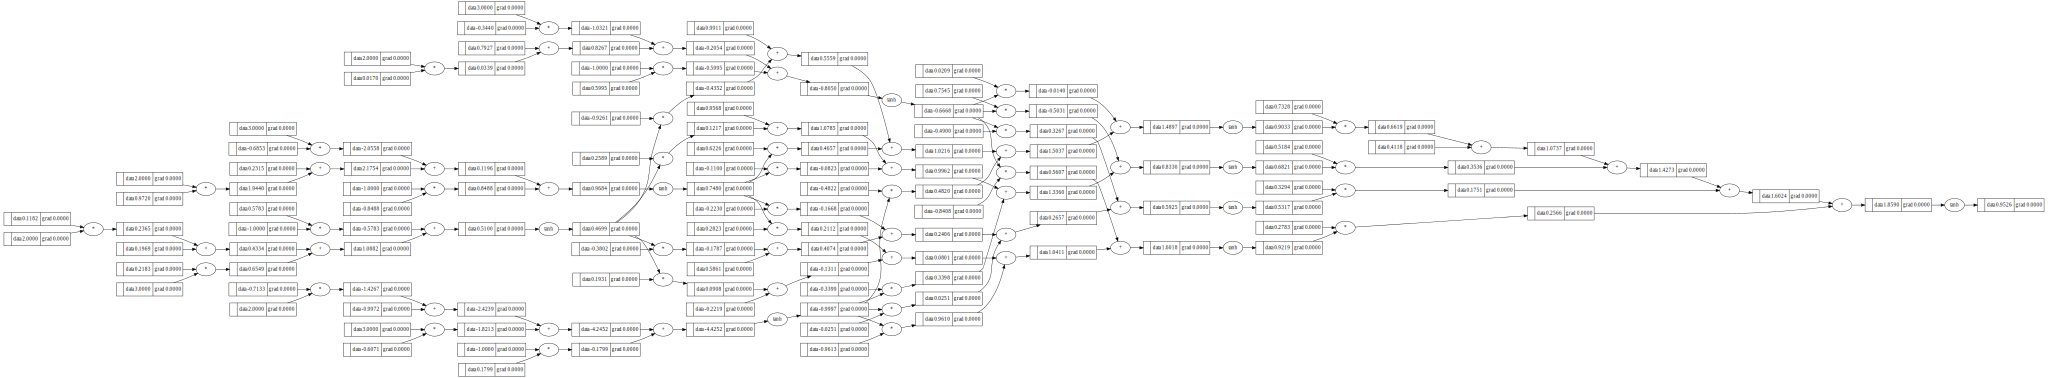

In [73]:
draw_dot(n(x))


In [74]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9525873989242399),
 Value(data=0.9210856025699679),
 Value(data=0.8225770067835327),
 Value(data=0.9566408564254553)]

In [79]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

TypeError: ignored

In [71]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [72]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7501723855635638)

In [73]:
len(n.parameters())

41

In [74]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [85]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

  for p in n.parameters():
    p.grad = 0.0
  for l in loss:

    l.backward()

  for p in n.parameters():
    p.data += -0.1 * p.grad

  # # backward pass
  # for p in n.parameters():
  #   p.grad = 0.0
  # loss.backward()

  # # update
  # for p in n.parameters():
  #   p.data += -0.1 * p.grad
  total_sum = sum(item.data for item in loss)
  print(k, total_sum)

0 0.001142587812905543
1 0.001137152987585031
2 0.0011317693264273922
3 0.001126436104734141
4 0.0011211526115839543
5 0.0011159181495028505
6 0.0011107320341439775
7 0.0011055935939765752
8 0.001100502169983838
9 0.001095457115369403
10 0.0010904577952721415
11 0.0010855035864889672
12 0.001080593877205481
13 0.0010757280667340102
14 0.0010709055652590967
15 0.0010661257935898278
16 0.0010613881829191745
17 0.001056692174589685
18 0.001052037219865768
19 0.001047422779712038


In [61]:
ypred = [n(x) for x in xs]
loss = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
total_sum = sum(item.data for item in loss)
print(total_sum)
# print(loss)

0.00013075518250374224


In [56]:
for l in loss:
  l.backward()

In [57]:
for p in n.parameters():
  p.data += -0.1 * p.grad

In [77]:
ypred

[Value(data=0.9760381669676987),
 Value(data=-0.9891745230217555),
 Value(data=-0.9527689076176827),
 Value(data=0.9741211275196959)]

In [59]:
n.parameters()

[Value(data=0.6624930437100607),
 Value(data=-3.1071751315514327),
 Value(data=2.7522292984641754),
 Value(data=0.868464249011437),
 Value(data=1.0666612077978632),
 Value(data=1.057855271381472),
 Value(data=0.4448854542696409),
 Value(data=1.7511689183678227),
 Value(data=2.648486956543888),
 Value(data=3.9341461741510444),
 Value(data=-7.124227169022973),
 Value(data=0.020515772477451233),
 Value(data=-4.544550355835991),
 Value(data=-1.6347577393454247),
 Value(data=-2.7567738173420286),
 Value(data=-3.871734615148802),
 Value(data=5.281311654108484),
 Value(data=-2.1743670430000033),
 Value(data=-4.162647574803971),
 Value(data=0.035099841186531144),
 Value(data=1.2877907215442668),
 Value(data=0.8969208446041524),
 Value(data=-0.7690766152298681),
 Value(data=0.021222616335255753),
 Value(data=0.030684470474349274),
 Value(data=0.09861989456237832),
 Value(data=0.8783124141404286),
 Value(data=-0.46176881083867427),
 Value(data=0.316482102475034),
 Value(data=0.42317529635326967)

In [85]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

AttributeError: ignored

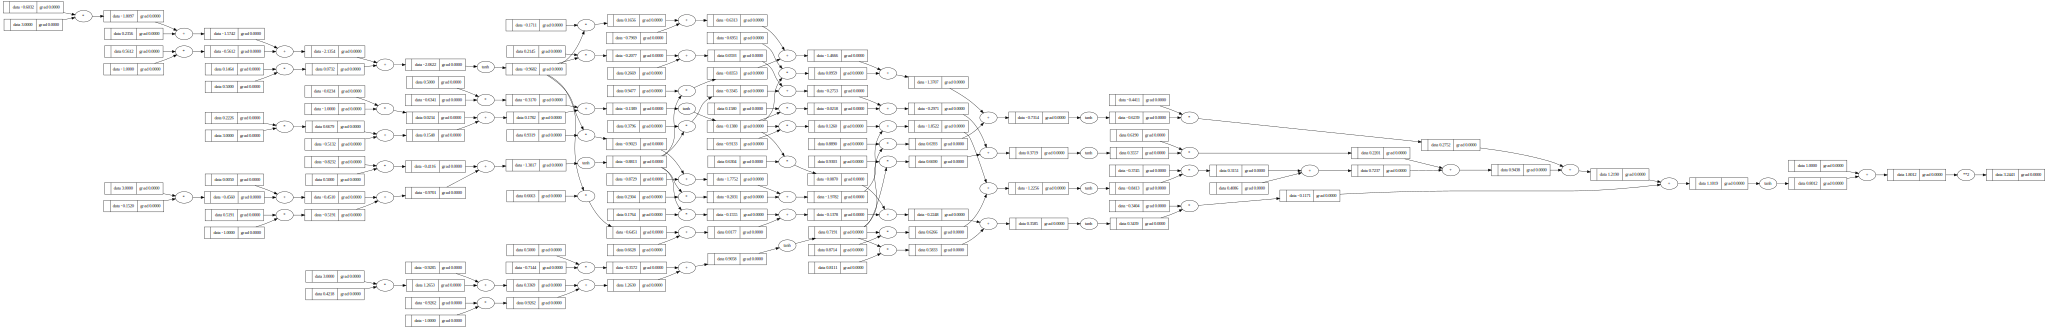

In [92]:
draw_dot(loss[1])

most common neural net mistakes: 1) you didn't try to overfit a single batch first. 2) you forgot to toggle train/eval mode for the net. 3) you forgot to .zero_grad() (in pytorch) before .backward(). 4) you passed softmaxed outputs to a loss that expects raw logits;

5) you didn't use bias=False for your Linear/Conv2d layer when using BatchNorm, or conversely forget to include it for the output layer .This one won't make you silently fail, but they are spurious parameters

6) thinking view() and permute() are the same thing (& incorrectly using view)